In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Imputer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
# Create a SparkSession
spark = SparkSession.builder.appName("EnergyConsumption").getOrCreate()

23/12/26 19:34:21 WARN Utils: Your hostname, Riddhishas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.219 instead (on interface en0)
23/12/26 19:34:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/26 19:34:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
mydata = spark.read.csv('cleaned_data.csv', header=True, inferSchema=True)

In [6]:
mydata.printSchema()

root
 |-- Invoice_ID: integer (nullable = true)
 |-- Account_Number: string (nullable = true)
 |-- Energy_Type_Name: string (nullable = true)
 |-- Invoice_Date: date (nullable = true)
 |-- From_Date: date (nullable = true)
 |-- To_Date: date (nullable = true)
 |-- Usage_Period_Days: integer (nullable = true)
 |-- Delivery_Cost: double (nullable = true)
 |-- Supply_Cost: double (nullable = true)
 |-- Total_Cost: double (nullable = true)
 |-- Total_Consumption: double (nullable = true)
 |-- Street_Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zip: string (nullable = true)
 |-- State_Name: string (nullable = true)
 |-- Abbreviation: string (nullable = true)
 |-- Country_Name: string (nullable = true)
 |-- Site_Name: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Code_Description: string (nullable = true)
 |-- Department_Name: string (nullable = true)
 |-- Year: integer (nullable = true)



In [7]:
# Display the first few rows of the DataFrame
mydata.show()

+----------+--------------+----------------+------------+----------+----------+-----------------+-------------+-----------+----------+-----------------+--------------------+------+----+-------------+------------+-------------+--------------------+--------+--------------------+---------------+----+
|Invoice_ID|Account_Number|Energy_Type_Name|Invoice_Date| From_Date|   To_Date|Usage_Period_Days|Delivery_Cost|Supply_Cost|Total_Cost|Total_Consumption|      Street_Address|  City| Zip|   State_Name|Abbreviation| Country_Name|           Site_Name|Currency|    Code_Description|Department_Name|Year|
+----------+--------------+----------------+------------+----------+----------+-----------------+-------------+-----------+----------+-----------------+--------------------+------+----+-------------+------------+-------------+--------------------+--------+--------------------+---------------+----+
|   6590186|    9504656628|           Steam|  2014-12-01|2014-10-30|2014-12-01|               32|      

In [8]:
# Display the column names
mydata.columns

['Invoice_ID',
 'Account_Number',
 'Energy_Type_Name',
 'Invoice_Date',
 'From_Date',
 'To_Date',
 'Usage_Period_Days',
 'Delivery_Cost',
 'Supply_Cost',
 'Total_Cost',
 'Total_Consumption',
 'Street_Address',
 'City',
 'Zip',
 'State_Name',
 'Abbreviation',
 'Country_Name',
 'Site_Name',
 'Currency',
 'Code_Description',
 'Department_Name',
 'Year']

In [9]:
# Display the descriptive statistics for all columns
mydata.describe().show()

23/12/26 19:36:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+--------------------+----------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+-------+------------------+-------------+------------+-------------+----------------+--------+--------------------+------------------+------------------+
|summary|          Invoice_ID|      Account_Number|Energy_Type_Name| Usage_Period_Days|    Delivery_Cost|       Supply_Cost|       Total_Cost| Total_Consumption|      Street_Address|   City|               Zip|   State_Name|Abbreviation| Country_Name|       Site_Name|Currency|    Code_Description|   Department_Name|              Year|
+-------+--------------------+--------------------+----------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+-------+------------------+-------------+------------+-------------+----------------+--------+--------------------+------------------+------------

In [10]:
# Split the data into train and test sets
train_data, test_data = mydata.randomSplit([0.8, 0.2], seed=42)

# Create a VectorAssembler to combine features
assembler = VectorAssembler(inputCols=['Supply_Cost', 'Delivery_Cost', 'Total_Cost'], outputCol='features')
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Create a Linear Regression model
lr = LinearRegression(labelCol='Total_Consumption', predictionCol='Total_Consumption_pred')

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model's performance
evaluator = RegressionEvaluator(labelCol='Total_Consumption', predictionCol='Total_Consumption_pred', metricName='mse')
mse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("Mean Squared Error:", mse)
print("R-squared:", r2)

23/12/26 19:37:41 WARN Instrumentation: [82b6e797] regParam is zero, which might cause numerical instability and overfitting.
23/12/26 19:37:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/26 19:37:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/12/26 19:37:46 WARN Instrumentation: [82b6e797] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Mean Squared Error: 345714731.62008077
R-squared: 0.568036198832613


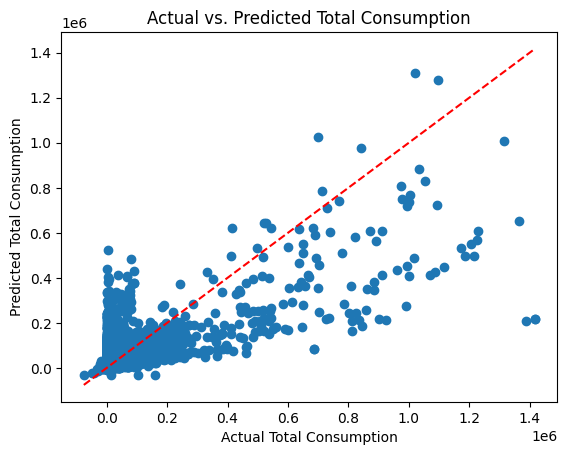

In [11]:
# Plot the predicted values against the actual values
actual_pred = predictions.select('Total_Consumption', 'Total_Consumption_pred').toPandas()
plt.scatter(actual_pred['Total_Consumption'], actual_pred['Total_Consumption_pred'])
plt.plot([actual_pred['Total_Consumption'].min(), actual_pred['Total_Consumption'].max()], [actual_pred['Total_Consumption'].min(), actual_pred['Total_Consumption'].max()], 'r--')
plt.xlabel('Actual Total Consumption')
plt.ylabel('Predicted Total Consumption')
plt.title('Actual vs. Predicted Total Consumption')
plt.show()

In [12]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Split the data into train and test sets
train_data, test_data = mydata.randomSplit([0.8, 0.2], seed=42)

# Create a VectorAssembler to combine features
assembler = VectorAssembler(inputCols=['Supply_Cost', 'Delivery_Cost', 'Total_Cost'], outputCol='features')
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Create a Gradient Boosting Regression model
gbt = GBTRegressor(labelCol='Total_Consumption', predictionCol='Total_Consumption_pred1')

# Fit the model on the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
predictions = gbt_model.transform(test_data)

# Evaluate the model's performance
evaluator = RegressionEvaluator(labelCol='Total_Consumption', predictionCol='Total_Consumption_pred1', metricName='mse')
mse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 620087445.4715831
R-squared: 0.2252128546942097


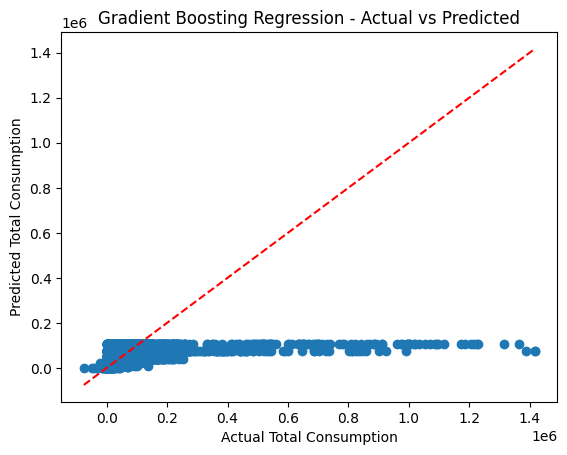

In [13]:
# Transfer the predictions and actual values to a local machine for plotting
y_test = predictions.select("Total_Consumption").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("Total_Consumption_pred1").rdd.flatMap(lambda x: x).collect()

# Plot the predicted values against the actual values
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Plot the 45-degree line
plt.xlabel('Actual Total Consumption')
plt.ylabel('Predicted Total Consumption')
plt.title('Gradient Boosting Regression - Actual vs Predicted')
plt.show()